### Файл train.ipynb
Тетрадка с кодом обучения модели,
которая при запуске Run без дополнительных
модификаций, позволяет получить ту же самую
модель, которая используется для прогноза в
следующем ноутбуке (main.ipynb).

In [1]:
!git clone https://github.com/samoletpanfilov/reinforcement_task.git

fatal: destination path 'reinforcement_task' already exists and is not an empty directory.


### Установка зависимостей

In [2]:
!pip install tsfresh catboost

### Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import re
import os
import shutil
from io import BytesIO

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

import xgboost as xgb

from catboost import CatBoostRegressor

import pickle

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

### Загрузка данных

In [4]:
# Загрузка данных для XGBoost модели
test = pd.read_excel("/content/reinforcement_task/data/test.xlsx")
train = pd.read_excel("/content/reinforcement_task/data/train.xlsx")
sample_submission = pd.read_excel("/content/reinforcement_task/sample_submission.xlsx")

# Загрузка дополнительных данных для CatBoost модели
data_dir = '/content/reinforcement_task/data/'

df_chmf = pd.read_csv(os.path.join(data_dir, "CHMF Акции.csv")).rename(columns={"Date": "timestamp"})
df_magn = pd.read_csv(os.path.join(data_dir, "MAGN Акции.csv")).rename(columns={"Дата": "timestamp"})
df_nlmk = pd.read_csv(os.path.join(data_dir, "NLMK Акции.csv")).rename(columns={"Date": "timestamp"})
df_transfer = pd.read_excel(os.path.join(data_dir, "Грузоперевозки.xlsx")).rename(
    columns={"dt": "timestamp", "Индекс стоимости грузоперевозок": "transfer_cost"})
df_market = pd.read_excel(os.path.join(data_dir, "Данные рынка стройматериалов.xlsx")).rename(columns={"dt": "timestamp"})
df_lme = pd.read_excel(os.path.join(data_dir, "Индекс LME.xlsx")).rename(columns={"дата": "timestamp"})
df_macro = pd.read_excel(os.path.join(data_dir, "Макропоказатели.xlsx")).rename(columns={"dt": "timestamp"})
df_fuel = pd.read_excel(os.path.join(data_dir, "Топливо.xlsx")).rename(columns={"dt": "timestamp"})
df_raw_prices = pd.read_excel(os.path.join(data_dir, "Цены на сырье.xlsx")).rename(columns={"dt": "timestamp"})

# Подготовка данных

In [5]:
# Подготовка тренировочной выборки
df_train_xgb = pd.DataFrame()
df_train_xgb['Date'] = pd.to_datetime(train['dt'])
df_train_xgb['Price'] = train['Цена на арматуру']
df_train_xgb['istest'] = 0

# Подготовка тестовой выборки
df_test_xgb = pd.DataFrame()
df_test_xgb['Date'] = pd.to_datetime(test['dt'])
df_test_xgb['Price'] = test['Цена на арматуру']
df_test_xgb['istest'] = 1

# Объединение тренировочной и тестовой выборок
raw_xgb = pd.concat((df_train_xgb, df_test_xgb)).reset_index(drop=True)

# Выделяем временные признаки
raw_xgb["day_sin"] = np.sin(raw_xgb["Date"].dt.day)
raw_xgb["day_cos"] = np.cos(raw_xgb["Date"].dt.day)

# Посмотрим на тип переменных
raw_xgb.dtypes

,0
Date,datetime64[ns]
Price,int64
istest,int64
day_sin,float64
day_cos,float64


In [6]:
raw_xgb.head(7)

,Date,Price,istest,day_sin,day_cos
0,2015-01-05,32900,0,-0.958924,0.283662
1,2015-01-12,32500,0,-0.536573,0.843854
2,2015-01-19,32000,0,0.149877,0.988705
3,2015-01-26,30700,0,0.762558,0.646919
4,2015-02-02,30300,0,0.909297,-0.416147
5,2015-02-09,30300,0,0.412118,-0.911130
6,2015-02-16,30100,0,-0.287903,-0.957659


In [7]:
# Создаем матрицы со сдвигом
X_xgb = raw_xgb.drop(columns=['Price']).iloc[:-1, :]
y_xgb = raw_xgb['Price'].values[1:]

X_xgb['Price_target'] = y_xgb
X_xgb['Price_source'] = raw_xgb['Price'].values[:-1]

# Вычисляем разницу цен
price_diff = X_xgb['Price_source'] - X_xgb['Price_target']

# Удаляем первую строку
X_xgb = X_xgb.drop([0])

# Добавляем разницу в цене
X_xgb['Price_Diff'] = price_diff.values[:-1]

In [8]:
# Посмотрим на конец тренировочной выборки
X_xgb[X_xgb['istest'] == 0].tail()

,Date,istest,day_sin,day_cos,Price_target,Price_source,Price_Diff
395,2022-08-01,0,0.841471,0.540302,49000,47500,0
396,2022-08-08,0,0.989358,-0.145500,47500,49000,-1500
397,2022-08-15,0,0.650288,-0.759688,46500,47500,1500
398,2022-08-22,0,-0.008851,-0.999961,46000,46500,1000
399,2022-08-29,0,-0.663634,-0.748058,46000,46000,500


In [9]:
# Посмотрим на начало тестовой выборки
X_xgb[X_xgb['istest'] == 1].head()

,Date,istest,day_sin,day_cos,Price_target,Price_source,Price_Diff
400,2022-09-05,1,-0.958924,0.283662,46000,46000,0
401,2022-09-12,1,-0.536573,0.843854,46000,46000,0
402,2022-09-19,1,0.149877,0.988705,45500,46000,0
403,2022-09-26,1,0.762558,0.646919,45500,45500,500
404,2022-10-03,1,0.141120,-0.989992,45000,45500,0


In [10]:
# Удаление ненужных столбцов
y_xgb = X_xgb['Price_target']
X_xgb = X_xgb.drop(columns=['Price_target', 'Date'])

# Используем tsfresh для генерации признаков

In [11]:
# Используем следующий набор параметров

# Рассчитываются коэффициенты skewness и kurtosis, считается, сколько раз
# повторялось значение минимума и максимума, различные квантили, оконные
# статистики, автокорреляции и т. д.
settings_efficient = settings.EfficientFCParameters()
print(f"Количество используемых функций: {len(settings_efficient)}")

Количество используемых функций: 73


In [12]:
# Подготовка фреймов длины 5

data_for_tsfresh = X_xgb['Price_source'].values
indexes = list(range(len(data_for_tsfresh), 4, -1))

ts_for_tsfresh = []

for i in range(len(indexes)):
    indexes_ts = indexes[i:i+6][::-1]
    values_ts = data_for_tsfresh[indexes_ts[0]:indexes_ts[-1]]
    if len(values_ts) < 5:
        break
    ts_for_tsfresh.append(values_ts)

ts_for_tsfresh = pd.DataFrame(ts_for_tsfresh[::-1])

In [13]:
# Создание фрейма необходимого формата для выделения признаков
data_long = pd.DataFrame({'data': ts_for_tsfresh.values.flatten(),
                          'id': np.repeat(np.array(ts_for_tsfresh.index), 5)})

In [14]:
# Генерация признаков
X_tsfresh = extract_features(data_long, column_id='id', impute_function=impute, default_fc_parameters=settings_efficient)

Feature Extraction: 100%|██████████| 417/417 [00:54<00:00,  7.64it/s]


In [15]:
# Удаление пустых строк
X_xgb = X_xgb.drop(list(range(1, 10)))
y_xgb = y_xgb.drop(list(range(1, 10)))

# Reset индексов
X_xgb = X_xgb.reset_index(drop=True)
y_xgb = y_xgb.reset_index(drop=True)

In [16]:
# Добавляем выделенные признаки в тренировочную и тестовую выборки
for col in X_tsfresh.columns:
    X_xgb[col] = X_tsfresh[col]

In [17]:
X_xgb.head(12)

,istest,day_sin,day_cos,Price_source,Price_Diff,data__variance_larger_than_standard_deviation,data__has_duplicate_max,data__has_duplicate_min,data__has_duplicate,data__sum_values,...,data__fourier_entropy__bins_5,data__fourier_entropy__bins_10,data__fourier_entropy__bins_100,data__permutation_entropy__dimension_3__tau_1,data__permutation_entropy__dimension_4__tau_1,data__permutation_entropy__dimension_5__tau_1,data__permutation_entropy__dimension_6__tau_1,data__permutation_entropy__dimension_7__tau_1,data__query_similarity_count__query_None__threshold_0.0,data__mean_n_absolute_max__number_of_maxima_7
0,0,-0.287903,-0.957659,28700,300,1.0,0.0,0.0,0.0,146400.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
1,0,-0.846220,-0.532833,27800,900,1.0,0.0,0.0,0.0,144100.0,...,0.636514,0.636514,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
2,0,-0.988032,0.154251,27200,600,1.0,0.0,0.0,0.0,141900.0,...,0.636514,0.636514,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
3,0,-0.279415,0.960170,26600,600,1.0,0.0,0.0,0.0,139300.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
4,0,0.420167,0.907447,25700,900,1.0,0.0,0.0,0.0,136000.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
5,0,0.912945,0.408082,24800,900,1.0,0.0,0.0,0.0,132100.0,...,0.636514,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
6,0,0.956376,-0.292139,24700,100,1.0,0.0,0.0,0.0,129000.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
7,0,-0.756802,-0.653644,24300,400,1.0,0.0,0.0,0.0,126100.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
8,0,-0.999990,0.004426,23900,400,1.0,0.0,0.0,0.0,123400.0,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,-0.0,0.0,0.0,0.0,0.0
9,0,-0.750987,0.660317,24000,-100,1.0,0.0,0.0,0.0,121700.0,...,0.636514,1.098612,1.098612,0.636514,0.693147,-0.0,0.0,0.0,0.0,0.0


# Обучение моделей XGBoost

In [18]:
# Разделение тренировочной выборки на обучающую и отложенную выборки

# Маска для тренировочной выборки
X_for_train_xgb = (X_xgb['istest'] == 0)

X_train_xgb, X_holdout_xgb, y_train_xgb, y_holdout_xgb = train_test_split(
    X_xgb[X_for_train_xgb].drop(columns=['istest']),
    y_xgb[X_for_train_xgb], test_size=0.2, shuffle=False)

In [19]:
params = {
    'tree_method': "hist",
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_leaves': 31,
    'subsample': 0.60,
    'colsample_bytree': 0.50,
    'n_jobs': 2,
    'eval_metric': 'mae',
    'enable_categorical': True
}

# Инициализация модели №1 и её параметров
model0 = xgb.XGBRegressor(
    **params,
    random_state=17
)

# Инициализация модели №2 и её параметров
model1 = xgb.XGBRegressor(
    **params,
    random_state=25,
)

# Инициализация модели №3 и её параметров
model2 = xgb.XGBRegressor(
    **params,
    random_state=32,
)

In [20]:
# Обучение модели №1
model0.fit(
    X_train_xgb,
    y_train_xgb,
)

# Обучение модели №2
model1.fit(
    X_train_xgb,
    y_train_xgb,
)

# Обучение модели №3
model2.fit(
    X_train_xgb,
    y_train_xgb,
)

# Предсказывание значений на отложенной выборке
ypred_xgb = (model0.predict(X_holdout_xgb) +
         model1.predict(X_holdout_xgb) +
         model2.predict(X_holdout_xgb)) / 3

In [21]:
result_xgb = pd.DataFrame({'real': y_holdout_xgb[1:].values,
                           'pred': ypred_xgb[:-1]})
result_xgb['error'] = result_xgb['real'] - result_xgb['pred']
result_xgb.tail(12)

,real,pred,error
65,43000,45515.593750,-2515.593750
66,44000,44450.433594,-450.433594
67,45000,42993.738281,2006.261719
68,45500,44001.671875,1498.328125
69,47000,46815.121094,184.878906
70,47500,45975.488281,1524.511719
71,47500,47642.144531,-142.144531
72,49000,47388.386719,1611.613281
73,47500,47064.609375,435.390625
74,46500,52236.890625,-5736.890625


### Проверка на отложенной выборке

In [22]:
# Подсчет метрик прогноза на отложенной выборке
print("MAE на holdout-выборке:", mean_absolute_error(y_holdout_xgb, ypred_xgb))
print("MSE на holdout-выборке:", mean_squared_error(y_holdout_xgb, ypred_xgb))

MAE на holdout-выборке: 7444.08251953125
MSE на holdout-выборке: 85541640.0


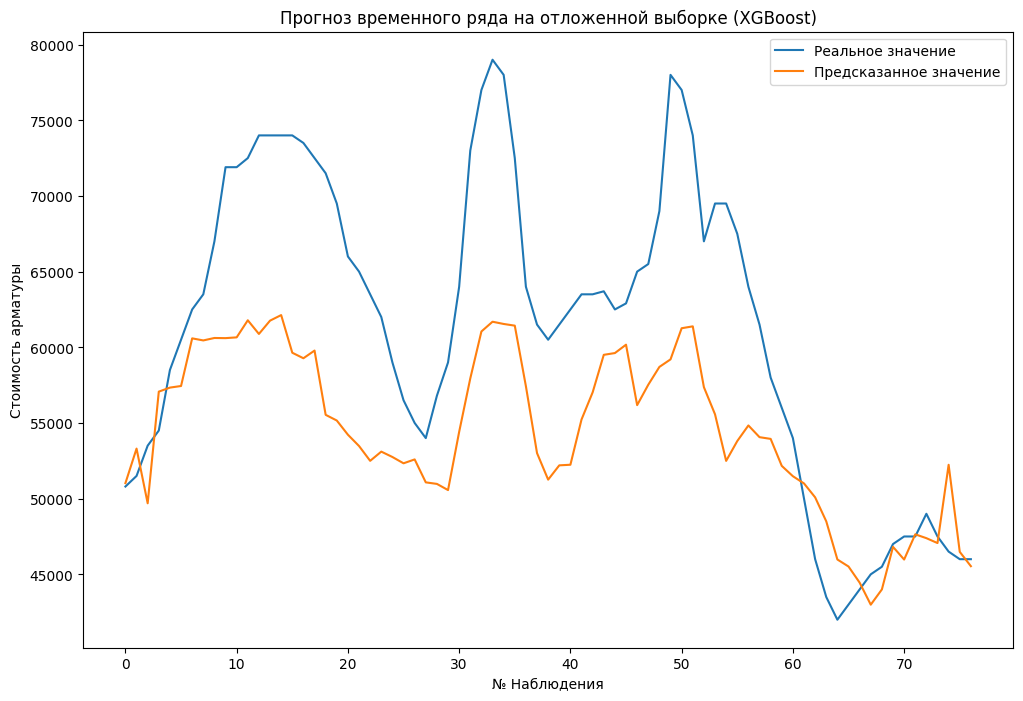

In [23]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=100)

plt.plot(result_xgb['real'], label='Реальное значение')
plt.plot(result_xgb['pred'], label='Предсказанное значение')
plt.title('Прогноз временного ряда на отложенной выборке (XGBoost)')
plt.xlabel('№ Наблюдения')
plt.ylabel('Стоимость арматуры')
plt.legend()
plt.show()

# Обучение на всей тренировочной выборке

In [24]:
model0.fit(X_xgb[X_for_train_xgb].drop(columns=['istest']), y_xgb[X_for_train_xgb])
model1.fit(X_xgb[X_for_train_xgb].drop(columns=['istest']), y_xgb[X_for_train_xgb])
model2.fit(X_xgb[X_for_train_xgb].drop(columns=['istest']), y_xgb[X_for_train_xgb])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=31,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=2,
             num_parallel_tree=None, random_state=32, ...)

### Сохраняем веса моделей


In [26]:
!mkdir models

In [27]:
pickle.dump(model0, open("models/xgb_reg1.pkl", "wb"))
pickle.dump(model1, open("models/xgb_reg2.pkl", "wb"))
pickle.dump(model2, open("models/xgb_reg3.pkl", "wb"))

# Подготовка данных для CatBoost модели

In [28]:
# Преобразование дат в datetime
df_chmf["timestamp"] = pd.to_datetime(df_chmf["timestamp"])
df_magn["timestamp"] = pd.to_datetime(df_magn["timestamp"])
df_nlmk["timestamp"] = pd.to_datetime(df_nlmk["timestamp"])

In [29]:
# Параметры модели
horizon = 10
month_length = 30
inf = 1000000000
test_size = int(400 * 0.2)

In [30]:
# Объединение датафреймов
df_train = train.rename(columns={"dt": "timestamp", "Цена на арматуру": "target"})
merged_df = pd.merge(df_train, df_chmf, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, df_magn, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, df_nlmk, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, df_transfer, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, df_market, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, df_lme, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, df_macro, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, df_fuel, on='timestamp', how='outer')
merged_df = pd.merge(merged_df, df_raw_prices, on='timestamp', how='outer')

# Сортировка по timestamp
merged_df.sort_values("timestamp", inplace=True)

In [31]:
# Добавление EMA признаков
for window in range(3, 2 * month_length):
    merged_df['EMA' + str(window)] = merged_df['target'].ewm(alpha=2 / (window + 1), adjust=False).mean()
    # merged_df['SMA' + str(window)] = merged_df['target'].rolling(window).mean()
    # merged_df['STD' + str(window)] = merged_df['target'].rolling(window).std()

In [32]:
# Удаление строк с NaN в target
merged_df = merged_df.dropna(subset=["target"])

# Преобразование нечисловых столбцов в числовые
for column in merged_df.columns:
    if column != "timestamp":
        # Проверка, содержит ли стобец числовые
        if merged_df[column].dtype != float and merged_df[column].dtype != int:
            # Извлечение числовых значений, используя регулярные выражения
            merged_df[column] = merged_df[column].apply(lambda x: re.findall(r"[-+]?\d*\.\d+|\d+", str(x))[0] if re.findall(r"[-+]?\d*\.\d+|\d+", str(x)) else np.nan)

            merged_df[column] = merged_df[column].astype(float)

merged_df["timestamp"] = pd.to_datetime(merged_df["timestamp"])

# Удаление столбцов с большим количеством NaN
nan_counts = merged_df.isna().sum()
columns_with_high_nan = nan_counts[nan_counts > merged_df.shape[0] * 0.5].index

if not os.path.exists("models"):
    os.mkdir("models")

with open("models/columns_with_high_nan.txt", "w", encoding='utf8') as file:
    file.write("\n".join(columns_with_high_nan))

merged_df = merged_df.drop(columns=columns_with_high_nan)

In [33]:
# Заполнение оставшихся NaN
merged_df = merged_df.fillna(method='ffill').fillna(method='bfill')

In [34]:
merged_df.head()

,timestamp,target,Ключевая ставка,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т",...,EMA50,EMA51,EMA52,EMA53,EMA54,EMA55,EMA56,EMA57,EMA58,EMA59
1,2015-01-05,32900.0,7.75,3850.0,228.0,12344.0,10009.0,12728.0,62.0,285.5,...,32900.000000,32900.000000,32900.000000,32900.000000,32900.000000,32900.000000,32900.000000,32900.000000,32900.000000,32900.000000
2,2015-01-12,32500.0,7.75,3850.0,228.0,12344.0,10009.0,12728.0,62.0,285.5,...,32884.313725,32884.615385,32884.905660,32885.185185,32885.454545,32885.714286,32885.964912,32886.206897,32886.440678,32886.666667
3,2015-01-19,32000.0,7.75,3850.0,228.0,12344.0,10009.0,12728.0,62.0,285.5,...,32849.634756,32850.591716,32851.512994,32852.400549,32853.256198,32854.081633,32854.878424,32855.648038,32856.391841,32857.111111
4,2015-01-26,30700.0,7.75,3850.0,228.0,12344.0,10009.0,12728.0,62.0,285.5,...,32765.335354,32767.876650,32770.323824,32772.682010,32774.955973,32777.150146,32779.268655,32781.315347,32783.293813,32785.207407
5,2015-02-02,30300.0,7.75,3850.0,228.0,12344.0,10009.0,12728.0,62.0,285.5,...,32668.655536,32672.958317,32677.104057,32681.101195,32684.957574,32688.680498,32692.276772,32695.752749,32699.114362,32702.367160


# Создание блоков данных для обучения CatBoost модели

In [35]:
df = merged_df.copy()
test_size = int(400 * 0.2)
df_train_full = df[:-test_size].copy().reset_index(drop=True)
df_test = df[-test_size:].copy().reset_index(drop=True)
df_test = df_test[['timestamp', 'target']]
df = df[horizon:].reset_index(drop=True)

# Поиск размера окна

In [36]:
# Поиск лучшего размера окна
best_window = 0
best_score = inf

for window in [4, 6, 8, 10, 12]:
    print("Обучение для размера окна:" + str(window))
    models_predictions = []
    for shift in tqdm(range(1, horizon)):
        # Создаем блоки данных с заданным сдвигом и окном
        upgrade_df = df[["timestamp"]].copy()
        rga, rgb = shift, shift + window

        x = np.array(df["target"] - df["target"].shift(rga)) / 100  # TODO
        x = x / (np.abs(x) + 1)  # SoftSign
        upgrade_df["target"] = x

        for col in df.columns:
            if col != "timestamp":
                for j in range(rga, rgb):
                    col1 = col + '_' + str(j)
                    if j != rga:
                        upgrade_df[col1] = df[col].shift(j) - df[col].shift(rga)
                    else:
                        upgrade_df[col1] = df[col].shift(j)

        # Удаляем первые 'horizon' строк
        upgrade_df = upgrade_df[horizon:].reset_index(drop=True)

        # Разделяем на обучающую и тестовую выборкии
        upgrade_train = upgrade_df[:-test_size].copy().reset_index(drop=True)
        upgrade_test = upgrade_df[-test_size:].copy().reset_index(drop=True)

        train_y = upgrade_train['target']
        train_x = upgrade_train.drop(columns=['target', "timestamp"])
        test_y = upgrade_test['target']
        test_x = upgrade_test.drop(columns=['target', "timestamp"])

        # Создаем и обучаем модель CatBoost
        model_cb = CatBoostRegressor(verbose=0)
        model_cb.fit(train_x, train_y)

        # Предсказание
        predictions = model_cb.predict(test_x)
        models_predictions.append(predictions)
        test_targets = test_y.values

    # Теперь используем models_predictions для принятия решений о заказах на временном сегменте
    result = []
    step = 0
    test_size_len = len(models_predictions[0])

    for day_ind in range(test_size_len):
        if step == 0:
            segment = [models_predictions[i][day_ind] for i in range(len(models_predictions))]
            # Находим индекс первого отрицательного предсказания
            for idx, num in enumerate(segment):
                if num < 0:
                    step = idx + 1
                    break
            else:
                step = len(segment)
            result.append(min(step, test_size_len - day_ind))
        else:
            result.append(0)
        step -= 1

    res = result

    print(res)
    # Обновляем df_test с новым столбцом 'Объем'
    df_test['Объем'] = res

    # Вычисляем оценку с использованием логики decision_prices
    df_test_copy = df_test.rename(columns={"timestamp": "dt"}).copy()
    test = df_test_copy.set_index('dt')
    tender_price = test['target']
    decision = test['Объем']
    start_date = test.index.min()
    end_date = test.index.max()

    _results = []
    _active_weeks = 0
    for report_date in pd.date_range(start_date, end_date, freq='W-MON'):
        if report_date in test.index:
            if _active_weeks == 0:  # Время для нового тендера
                _fixed_price = tender_price.loc[report_date]
                _active_weeks = int(decision.loc[report_date])
            _results.append(_fixed_price)
            _active_weeks += -1
        else:
            # Если report_date отсутствует в индексе, пропускаем
            continue
    cost = sum(_results)
    score = cost

    print("Оценка для размера окна " + str(window) + " составляет " + str(score))
    if best_score > score:
        best_score = score
        best_window = window
        y_pred_cb = models_predictions
        y_test_cb = test_targets

Обучение для размера окна:4


100%|██████████| 9/9 [11:33<00:00, 77.01s/it]


[1, 1, 2, 0, 4, 0, 0, 0, 1, 2, 0, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 1, 1, 1]
Оценка для размера окна 4 составляет 4833100.0
Обучение для размера окна:6


100%|██████████| 9/9 [17:22<00:00, 115.84s/it]


[1, 1, 2, 0, 4, 0, 0, 0, 1, 2, 0, 1, 2, 0, 4, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 4, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 0]
Оценка для размера окна 6 составляет 4825300.0
Обучение для размера окна:8


100%|██████████| 9/9 [23:32<00:00, 156.89s/it]


[1, 1, 1, 3, 0, 0, 1, 1, 2, 0, 1, 1, 2, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 4, 0, 0, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 0]
Оценка для размера окна 8 составляет 4857700.0
Обучение для размера окна:10


100%|██████████| 9/9 [29:24<00:00, 196.02s/it]


[1, 1, 1, 3, 0, 0, 1, 1, 2, 0, 1, 1, 2, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 3, 0, 0, 4, 0, 0, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0]
Оценка для размера окна 10 составляет 4832100.0
Обучение для размера окна:12


100%|██████████| 9/9 [35:27<00:00, 236.37s/it]

[1, 1, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 3, 0, 0, 3, 0, 0, 1, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Оценка для размера окна 12 составляет 4865200.0


In [37]:
print("Лучший размер окна:", str(best_window), "с оценкой:", str(best_score))

Лучший размер окна: 6 с оценкой: 4825300.0


# Повторное обучение CatBoost модели с лучшим размером окна

In [38]:
# Теперь создаем финальную модель, используя найденный лучший размер окна
shift_values = list(range(1, horizon))
models_predictions_full = []

print("Обучение финальных моделей на всех данных...")
for shift in tqdm(shift_values):
    # Создаем блоки данных с заданным сдвигом и best_window
    upgrade_df = df[["timestamp"]].copy()
    rga, rgb = shift, shift + best_window

    x = np.array(df["target"] - df["target"].shift(rga)) / 100  # TODO
    x = x / (np.abs(x) + 1)  # SoftSign
    upgrade_df["target"] = x

    for col in df.columns:
        if col != "timestamp":
            for j in range(rga, rgb):
                col1 = col + '_' + str(j)
                if j != rga:
                    upgrade_df[col1] = df[col].shift(j) - df[col].shift(rga)
                else:
                    upgrade_df[col1] = df[col].shift(j)

    # Удаляем первые 'horizon' строк
    upgrade_df = upgrade_df[horizon:].reset_index(drop=True)

    # Поскольку is_full_data_train = True
    upgrade_train = upgrade_df.copy().reset_index(drop=True)
    upgrade_test = upgrade_df.copy().reset_index(drop=True)

    train_y = upgrade_train['target']
    train_x = upgrade_train.drop(columns=['target', "timestamp"])
    test_y = upgrade_test['target']
    test_x = upgrade_test.drop(columns=['target', "timestamp"])

    # Создаем и обучаем модель CatBoost
    model_cb = CatBoostRegressor(verbose=0)
    model_cb.fit(train_x, train_y)

    # Предсказываем
    predictions = model_cb.predict(test_x)
    models_predictions_full.append(predictions)

Обучение финальных моделей на всех данных...


100%|██████████| 9/9 [18:04<00:00, 120.54s/it]


# Оптимизируем cnt_models



In [39]:
best_score = inf
final_cnt_models = 0

print("Оптимизация количества используемых моделей (cnt_models)...")
for cnt_models in range(1, len(models_predictions_full) + 1):
    # Используем cnt_models
    risk_value = 0.5  # Начальное значение risk_value

    # Вычисляем результат
    result = []
    step = 0
    test_size_len = len(models_predictions_full[0])
    for day_ind in range(test_size_len):
        if step == 0:
            segment = [models_predictions_full[i][day_ind] for i in range(cnt_models)]
            # Применяем risk_value
            for idx in range(1, len(segment)):
                segment[idx] = (segment[0] * risk_value + segment[idx] * (1 - risk_value))
            # Находим подходящий индекс
            for idx, num in enumerate(segment):
                if num < 0:
                    step = idx + 1
                    break
            else:
                step = len(segment)
            result.append(min(step, test_size_len - day_ind))
        else:
            result.append(0)
        step -= 1

    res = result

    # Теперь вычисляем оценку
    df_test_copy = df_test.rename(columns={"timestamp": "dt"}).copy()
    test = df_test_copy.set_index('dt')
    tender_price = test['target']
    decision = res
    start_date = test.index.min()
    end_date = test.index.max()

    _results = []
    _active_weeks = 0
    for report_date in pd.date_range(start_date, end_date, freq='W-MON'):
        if report_date in test.index:
            if _active_weeks == 0:  # Время для нового тендера
                _fixed_price = tender_price.loc[report_date]
                _active_weeks = int(test['Объем'].loc[report_date])
            _results.append(_fixed_price)
            _active_weeks += -1
        else:
            continue
    cost = sum(_results)
    score = cost

    if score < best_score:
        best_score = score
        final_cnt_models = cnt_models

print("Лучшее значение cnt_models: " + str(final_cnt_models))

Оптимизация количества используемых моделей (cnt_models)...
Лучшее значение cnt_models: 1


# Оптимизируем risk_value

In [40]:
# Оптимизируем risk_value
best_score = inf
final_risk_value = 0
step_size = 0.05

print("Оптимизация risk_value...")
for risk_value in np.arange(0.1, 0.9, step_size):
    cnt_models = final_cnt_models

    # Вычисляем результат
    result = []
    step = 0
    test_size_len = len(models_predictions_full[0])
    for day_ind in range(test_size_len):
        if step == 0:
            segment = [models_predictions_full[i][day_ind] for i in range(cnt_models)]
            # Применяем risk_value
            for idx in range(1, len(segment)):
                segment[idx] = (segment[0] * risk_value + segment[idx] * (1 - risk_value))
            # Находим подходящий индекс
            for idx, num in enumerate(segment):
                if num < 0:
                    step = idx + 1
                    break
            else:
                step = len(segment)
            result.append(min(step, test_size_len - day_ind))
        else:
            result.append(0)
        step -= 1

    res = result

    # Теперь вычисляем оценку
    df_test_copy = df_test.rename(columns={"timestamp": "dt"}).copy()
    #test = df_test_copy.set_index('dt')
    tender_price = test['target']
    decision = res
    start_date = test.index.min()
    end_date = test.index.max()

    _results = []
    _active_weeks = 0
    for report_date in pd.date_range(start_date, end_date, freq='W-MON'):
        if report_date in test.index:
            if _active_weeks == 0:  # Время для нового тендера
                _fixed_price = tender_price.loc[report_date]
                _active_weeks = int(test['Объем'].loc[report_date])
            _results.append(_fixed_price)
            _active_weeks += -1
        else:
            continue
    cost = sum(_results)
    score = cost

    if score < best_score:
        best_score = score
        final_risk_value = risk_value

print("Лучшее значение risk_value: " + str(final_risk_value))

Оптимизация risk_value...
Лучшее значение risk_value: 0.1


# Параметры финальной модели

In [41]:
print("Параметры финальной модели:")
print("Размер окна:", best_window)
print("Количество используемых моделей (cnt_models):", final_cnt_models)
print("Risk Value:", final_risk_value)

Параметры финальной модели:
Размер окна: 6
Количество используемых моделей (cnt_models): 1
Risk Value: 0.1


### Сохраняем вес модели


In [42]:
# Сохраняем параметры финальной модели
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for idx, shift in enumerate(shift_values):
    model_cb = CatBoostRegressor(verbose=0)
    # Переобучаем модели на всех данных
    # Повторяем процесс обучения для каждой модели, чтобы сохранить их

    # Используем те же шаги подготовки данных, что и ранее
    # Создаем блоки данных с заданным сдвигом и best_window
    upgrade_df = df[["timestamp"]].copy()
    rga, rgb = shift, shift + best_window

    x = np.array(df["target"] - df["target"].shift(rga)) / 100  # TODO
    x = x / (np.abs(x) + 1)  # SoftSign
    upgrade_df["target"] = x

    for col in df.columns:
        if col != "timestamp":
            for j in range(rga, rgb):
                col1 = col + '_' + str(j)
                if j != rga:
                    upgrade_df[col1] = df[col].shift(j) - df[col].shift(rga)
                else:
                    upgrade_df[col1] = df[col].shift(j)

    # Удаляем первые 'horizon' строк
    upgrade_df = upgrade_df[horizon:].reset_index(drop=True)

    # Поскольку is_full_data_train = True
    upgrade_train = upgrade_df.copy().reset_index(drop=True)

    train_y = upgrade_train['target']
    train_x = upgrade_train.drop(columns=['target', "timestamp"])

    model_cb.fit(train_x, train_y)
    # Сохраняем модель
    model_cb.save_model(model_dir + "cb_model_" + str(shift) + ".cbm")

# Сохраняем risk_value и cnt_models
with open(model_dir + "metamodel_ctb.mmm", "w", encoding='utf8') as file:
    file.write(str(final_risk_value) + "\n")
    file.write(str(final_cnt_models) + "\n")